# 102 Evaluate the uncertainty of object postions measured by ZED camera

In [ ]:
load_from_config = True
raw_data_folder = ""
preprocessed_data_folder = ""

In [14]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import numpy as np

In [15]:
with open('../config.yaml') as file:
  params= yaml.safe_load(file)

In [ ]:
# in case of a automatic run
if not load_from_config:
    params['raw_data_folder'] = raw_data_folder
    params['preprocessed_data_folder'] = preprocessed_data_folder

In [16]:
preprocessed_data_folder = params['data_folder'] + params['preprocessed_data_folder']
df_humans = pd.read_pickle(preprocessed_data_folder + 'pp_humans.pkl')

## Aggregating uncertainty data for object positions measured by ZED camera

https://github.com/stereolabs/zed-c-api/blob/02b4b7b1189f7316910637d7c496e3df9b6417e4/include/sl/c_api/types_c.h#L2632

```
/**
	\brief Covariance matrix of the 3D position.
	\note It is represented by its upper triangular matrix value
	\code
			= [p0, p1, p2]
			[p1, p3, p4]
			[p2, p4, p5]
	\endcode
	where pi is ```position_covariance[i]```
	 */
```

In [17]:
# https://cookierobotics.com/007/
# https://stackoverflow.com/questions/67718828/how-can-i-plot-an-ellipse-from-eigenvalues-and-eigenvectors-in-python-matplotl

def get_eigen_params(row):
    C = np.array([[row['obj.position_covariance.0'], row['obj.position_covariance.1'], row['obj.position_covariance.2']],
                  [row['obj.position_covariance.1'], row['obj.position_covariance.3'], row['obj.position_covariance.4']],
                  [row['obj.position_covariance.2'], row['obj.position_covariance.4'], row['obj.position_covariance.5']]])
    eigenvalues, eigenvectors = np.linalg.eig(C[0:2, 0:2])
    return eigenvalues, eigenvectors

In [18]:
# Welche Tracks sind interessant?

df_humans[df_humans['obj.label_id_unique'] < 20000]\
    .groupby('obj.label_id_unique')['obj.tracking_state']\
    .count()\
    .sort_values(ascending=False).head(15)

obj.label_id_unique
11272    1859
10792     441
11569     324
11258     286
11563     266
10193     260
10175     251
10176     248
10802     228
10244     217
11254     203
10789     198
10332     193
11332     192
10642     180
Name: obj.tracking_state, dtype: int64

(0.0, 12.0)

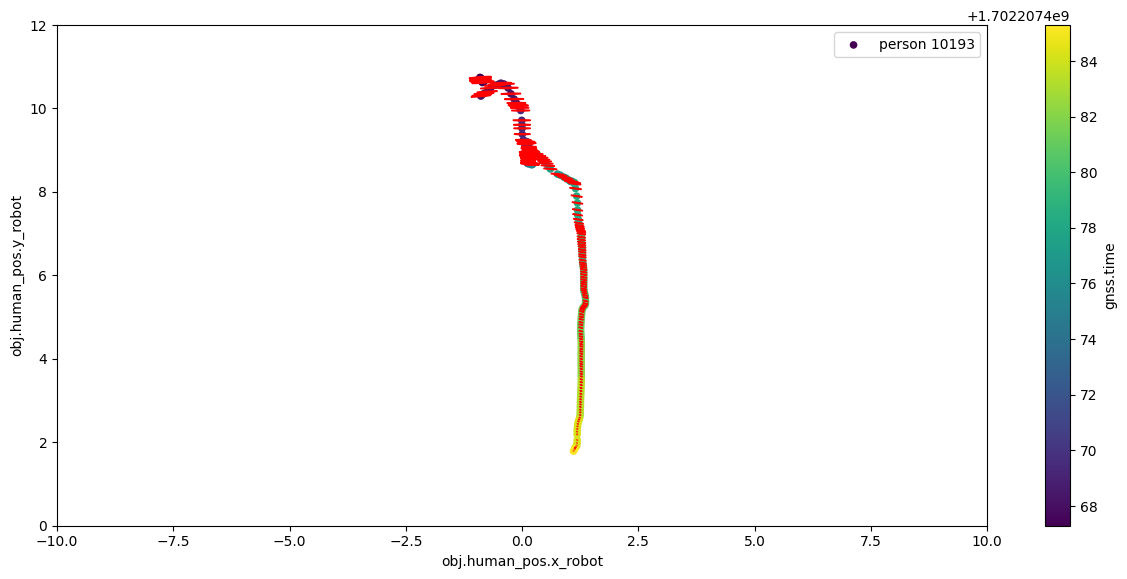

In [19]:
# https://www.youtube.com/watch?v=xXhLvheEF7o

def plot_poses(df, id, ax):
    df = df[df['obj.label_id_unique'] == id]
    df.plot.scatter(x='obj.human_pos.x_robot', y='obj.human_pos.y_robot', c='gnss.time', ax=ax, label=f'person {id}')
    for item, row in df.iterrows():
        eigenvalues, eigenvectors = get_eigen_params(row)
        angle = np.arctan2(eigenvectors[1,0], eigenvectors[0,0])
        width, height = 2.45*np.sqrt(eigenvalues)  # 2.45 is the 95% confidence interval
        width, height = 3.72*np.sqrt(eigenvalues)  # 3.72 is the 99% confidence interval
        ellipse = plt.matplotlib.patches.Ellipse((row['obj.human_pos.x_robot'], row['obj.human_pos.y_robot']), 
                                                width, height, angle=angle*180/np.pi, fill=False, edgecolor='r')
        ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(15,6.5))
plot_poses(df_humans, 10193, ax)
ax.set_xlim(-10, 10)
ax.set_ylim(0, 12)

In [20]:
def calculate_cov_area(row, selection=0):
    eigenvalues, eigenvectors = get_eigen_params(row)
    angle = np.arctan2(eigenvectors[1,0], eigenvectors[0,0])
    width, height = 2.45*np.sqrt(eigenvalues)  # 2.45 is the 95% confidence interval
    width, height = 3.72*np.sqrt(eigenvalues)  # 3.72 is the 99% confidence interval
    if selection == 0:
        return width / 2 *height / 2 * np.pi
    if selection == 1:
        return angle
    if selection == 2:
        return width
    if selection == 3:
        return height

df_humans['obj.cov_area'] = df_humans.apply(lambda row: calculate_cov_area(row), axis=1)
df_humans['obj.cov_angle'] = df_humans.apply(lambda row: calculate_cov_area(row, 1), axis=1)
df_humans['obj.cov_width'] = df_humans.apply(lambda row: calculate_cov_area(row, 2), axis=1)
df_humans['obj.cov_heigth'] = df_humans.apply(lambda row: calculate_cov_area(row, 3), axis=1)

In [21]:
pd.to_pickle(df_humans, preprocessed_data_folder + params['preprocessed_file_labels']+ "humans.pkl")

## Testing

<Axes: xlabel='obj.human_pos.x_robot', ylabel='obj.human_pos.y_robot'>

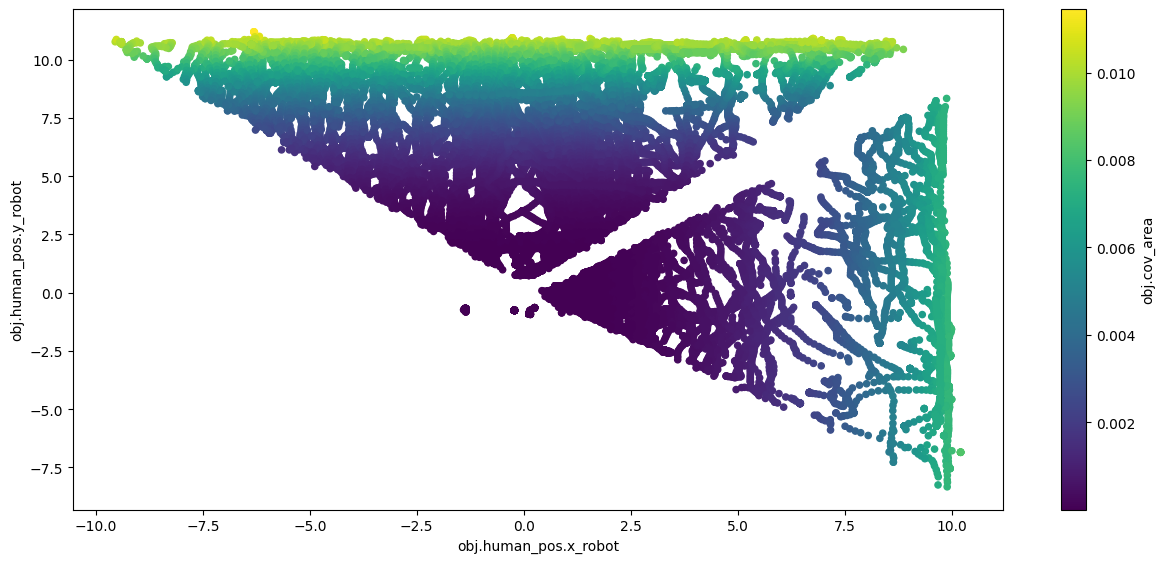

In [22]:
df_humans.plot.scatter(x='obj.human_pos.x_robot', y='obj.human_pos.y_robot', c='obj.cov_area', colormap='viridis', figsize=(15,6.5))

<Axes: xlabel='obj.human_pos.x_robot', ylabel='obj.human_pos.y_robot'>

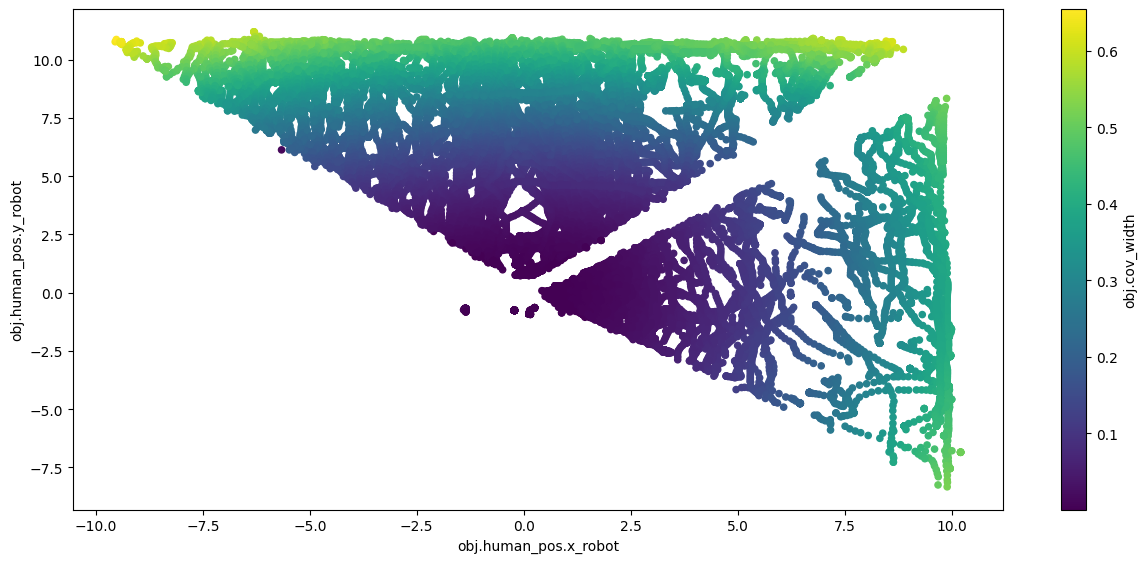

In [23]:
df_humans.plot.scatter(x='obj.human_pos.x_robot', y='obj.human_pos.y_robot', c='obj.cov_width', colormap='viridis', figsize=(15,6.5))

<Axes: xlabel='obj.human_pos.x_robot', ylabel='obj.human_pos.y_robot'>

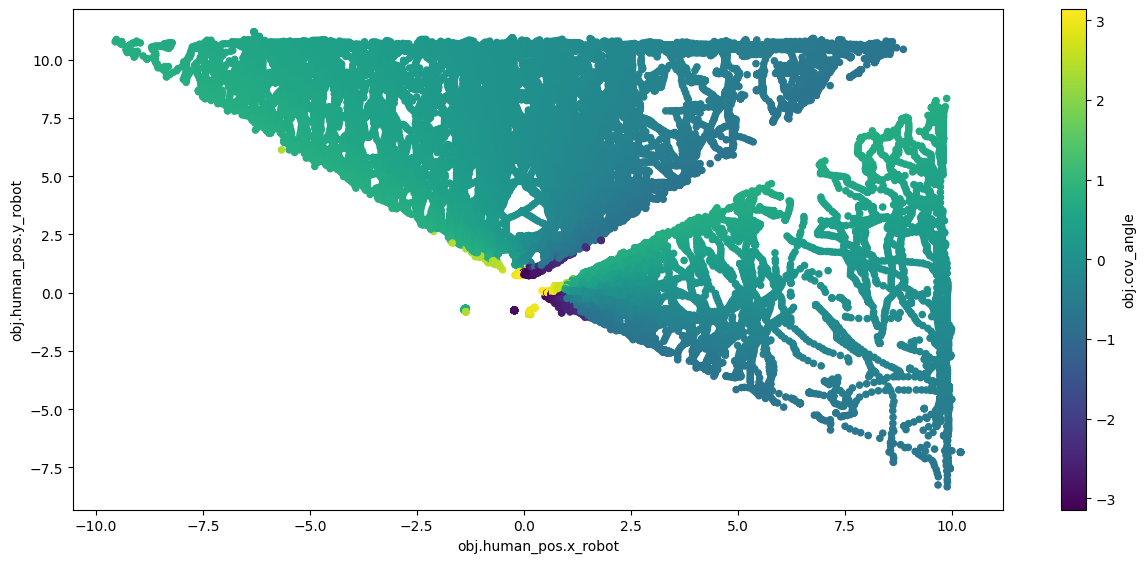

In [24]:
df_humans.plot.scatter(x='obj.human_pos.x_robot', y='obj.human_pos.y_robot', c='obj.cov_angle', colormap='viridis', figsize=(15,6.5))